In [1]:

import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5'
bump_normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5'
position_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.position.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])
with h5py.File(bump_normal_path, 'r') as f:
    bump_normal_map = np.array(f['dataset'])

with h5py.File(position_path, "r") as f:
        world_coordinates = np.array(f["dataset"])  

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
bump_normal_map = bump_normal_map.astype(np.float32)
world_coordinates = world_coordinates.astype(np.float32)
# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

In [45]:
import numpy as np
import h5py  # For reading HDF5 files

def are_lines_coplanar(line1, line2, threshold=1e-6):
    """
    Check if two lines are coplanar.
    line1 and line2 are tuples of two 3D points (P1, P2) and (P3, P4) respectively.
    """
    P1, P2 = line1
    P3, P4 = line2

    # Direction vectors of the lines
    d1 = P2 - P1
    d2 = P4 - P3

    # Vector between a point on line1 and a point on line2
    P1P3 = P3 - P1

    # Scalar triple product to check coplanarity
    triple_product = np.dot(np.cross(d1, d2), P1P3)

    # If the triple product is close to zero, the lines are coplanar
    return abs(triple_product) < threshold

def find_coplanar_lines(lines, normal_map, world_coordinates, normal_threshold=0.99):
    """
    Find coplanar lines using world coordinates and normal map.
    lines: List of lines, where each line is represented as a list of pixel coordinates [(x1, y1), (x2, y2)].
    normal_map: HxWx3 array of surface normals.
    world_coordinates: HxWx3 array of world-space positions.
    normal_threshold: Threshold for normal similarity (dot product).
    """
    coplanar_pairs = []
    coplanars = [False] * len(pred_lines)
    coplanar_dict = []
    for i in range(len(pred_lines)):
        coplanar_dict.append([False] * len(pred_lines))

    height, width = depth_map.shape    
    # Iterate over all pairs of lines
    for i in range(len(lines)):
        for j in range(len(lines)):
            line1 = lines[i]
            line2 = lines[j]
             # Convert line coordinates to integers and clip to image dimensions
            x1, y1 = int(np.clip(line1[0][0], 0, width - 1)), int(np.clip(line1[0][1], 0, height - 1))
            x2, y2 = int(np.clip(line1[1][0], 0, width - 1)), int(np.clip(line1[1][1], 0, height - 1))
            x3, y3 = int(np.clip(line2[0][0], 0, width - 1)), int(np.clip(line2[0][1], 0, height - 1))
            x4, y4 = int(np.clip(line2[1][0], 0, width - 1)), int(np.clip(line2[1][1], 0, height - 1))

            # Get world-space coordinates of the endpoints of the lines
            P1 = world_coordinates[y1, x1]  # (y1, x1)
            P2 = world_coordinates[y2, x2]  # (y2, x2)
            P3 = world_coordinates[y3, x3]  # (y3, x3)
            P4 = world_coordinates[y4, x4]  # (y4, x4)

            # Check if lines are coplanar
            if are_lines_coplanar((P1, P2), (P3, P4), 0.2):
                # Check if normals at the endpoints are similar
                normal1 = normal_map[y1, x1]
                normal2 = normal_map[y2, x2]
                normal3 = normal_map[y3, x3]
                normal4 = normal_map[y4, x4]

                normalmean1 = np.mean([normal1,normal2], axis=0)
                normalmean2 = np.mean([normal3, normal4], axis=0)
                normalmean1 /= np.linalg.norm(normalmean1)
                normalmean2 /= np.linalg.norm(normalmean2)

                # Compute dot products between normals
                #dot1 = np.dot(normal1, normal3)
                #dot2 = np.dot(normal2, normal4)

                # If normals are similar, the lines are coplanar
                if np.dot(normalmean1, normalmean2) > normal_threshold and not i == j:
                    coplanar_pairs.append((i, j))
                    coplanars[i] = True
                    coplanars[j] = True
                    coplanar_dict[i][j] = True

    return coplanar_pairs, coplanar_dict, coplanars

# Find coplanar lines
coplanar_pairs, coplanar_dict, coplanars = find_coplanar_lines(pred_lines, normal_map, world_coordinates)
print("Coplanar line pairs:", coplanar_pairs)




Coplanar line pairs: [(0, 5), (0, 9), (0, 25), (0, 59), (0, 99), (0, 125), (0, 171), (0, 237), (0, 261), (0, 275), (0, 288), (0, 298), (0, 321), (0, 322), (1, 24), (2, 3), (2, 11), (2, 16), (2, 37), (2, 40), (2, 46), (2, 72), (2, 83), (2, 91), (2, 94), (2, 97), (2, 111), (2, 135), (2, 136), (2, 150), (2, 213), (2, 229), (2, 230), (2, 268), (2, 269), (2, 353), (3, 2), (3, 28), (3, 40), (3, 72), (5, 0), (5, 61), (5, 65), (5, 126), (5, 314), (6, 59), (8, 15), (8, 21), (8, 62), (8, 69), (8, 148), (8, 170), (8, 178), (8, 190), (8, 194), (8, 195), (8, 197), (8, 205), (8, 240), (8, 257), (8, 281), (8, 308), (8, 310), (8, 316), (8, 319), (8, 339), (8, 344), (8, 355), (8, 357), (8, 368), (9, 0), (9, 25), (9, 59), (9, 99), (9, 124), (9, 125), (9, 134), (9, 171), (9, 237), (9, 261), (9, 288), (9, 293), (9, 298), (9, 302), (9, 321), (9, 322), (9, 337), (11, 2), (11, 16), (11, 37), (11, 40), (11, 46), (11, 72), (11, 83), (11, 91), (11, 94), (11, 97), (11, 111), (11, 135), (11, 136), (11, 150), (11,

In [96]:
import numpy as np
import h5py

def compute_plane(point, normal):
    """Compute plane equation: ax + by + cz + d = 0."""
    a, b, c = normal
    x0, y0, z0 = point
    d = - (a * x0 + b * y0 + c * z0)
    return (a, b, c, d)


def point_on_plane(plane, point, threshold=1e-3):
    """Check if a point lies on the plane."""
    a, b, c, d = plane
    distance = abs(a * point[0] + b * point[1] + c * point[2] + d)
    return distance < threshold

def are_lines_coplanar(line1_points, line1_normals, line2_points, line2_normals, normal_threshold=0.97):
    """
    Check if two lines are coplanar using their points and normals.
    """
    # Use the first point and normal of line1 to define the plane
    plane = compute_plane(line1_points[0], line1_normals[0])
    
    # Check if all points on line1 and line2 lie on the plane
    for point in np.vstack([line1_points, line2_points]):
        if not point_on_plane(plane, point, 0.1):
            return False
    
    # Check if normals are consistent with the plane's normal
    avg_normal_line1 = np.mean(line1_normals, axis=0)
    avg_normal_line2 = np.mean(line2_normals, axis=0)
    dot_product = np.dot(avg_normal_line1, avg_normal_line2)
    return dot_product > normal_threshold


def get_line_pixels(line, maps):
    """
    Get all pixel coordinates along a line using cv2.line.

    """
    # Extract line endpoints
    x1, y1 = int(line[0][0]), int(line[0][1])
    x2, y2 = int(line[1][0]), int(line[1][1])
    
    # Create a blank image of the same size as the maps
    height, width = maps.shape[:2]
    blank_image = np.zeros((height, width), dtype=np.uint8)
    
    # Draw the line on the blank image
    cv2.line(blank_image, (x1, y1), (x2, y2), color=255, thickness=1)
    
    # Extract pixel coordinates of the line
    y_coords, x_coords = np.where(blank_image == 255)
    
    # Return a list of (x, y) tuples
    return list(zip(x_coords, y_coords))
def find_coplanar_lines_using_planes(lines, normal_map, world_coordinates):
    """
    Find coplanar lines using plane equations derived from points and normals.
    """
    coplanar_pairs = []
    coplanar_pairs = []
    coplanars = [False] * len(pred_lines)
    coplanar_dict = []
    for i in range(len(pred_lines)):
        coplanar_dict.append([False] * len(pred_lines))

    height, width = depth_map.shape  
    
    # Precompute sampled points and normals for all lines
    line_data = []
    for line in lines:

        pixel_coords = get_line_pixels(line, depth_map)

        points = []
        normals = []
        for x, y in pixel_coords:
            x_clip = int(np.clip(x, 0, width - 1))
            y_clip = int(np.clip(y, 0, height - 1))
            points.append(world_coordinates[y_clip, x_clip])
            normals.append(normal_map[y_clip, x_clip])
        line_data.append({
            "points": np.array(points),
            "normals": np.array(normals),
        })
    
    # Compare all pairs of lines
    for i in range(len(lines)):
        for j in range(len(lines)):
            line1 = line_data[i]
            line2 = line_data[j]
            
            if are_lines_coplanar(
                line1["points"], line1["normals"],
                line2["points"], line2["normals"]
            ) and not i == j:
                coplanar_pairs.append((i, j))
                coplanars[i] = True
                coplanars[j] = True
                coplanar_dict[i][j] = True
    
    return coplanar_pairs, coplanar_dict, coplanars



coplanar_pairs, coplanar_dict, coplanars = find_coplanar_lines_using_planes(pred_lines, normal_map, world_coordinates)
print("Coplanar line pairs:", coplanar_pairs)

Coplanar line pairs: [(0, 9), (0, 25), (0, 125), (0, 171), (0, 237), (0, 261), (0, 288), (0, 298), (0, 321), (0, 322), (8, 15), (8, 21), (8, 62), (8, 69), (8, 80), (8, 148), (8, 157), (8, 170), (8, 178), (8, 190), (8, 194), (8, 195), (8, 197), (8, 205), (8, 240), (8, 257), (8, 281), (8, 308), (8, 310), (8, 316), (8, 319), (8, 339), (8, 344), (8, 355), (8, 357), (8, 368), (8, 384), (9, 0), (9, 25), (9, 125), (9, 171), (9, 237), (9, 261), (9, 288), (9, 298), (9, 321), (9, 322), (11, 16), (11, 37), (11, 40), (11, 46), (11, 83), (11, 91), (11, 94), (11, 97), (11, 111), (11, 135), (11, 136), (11, 150), (11, 213), (11, 229), (11, 230), (11, 268), (11, 269), (11, 353), (15, 8), (15, 21), (15, 69), (15, 148), (15, 170), (15, 178), (15, 190), (15, 194), (15, 195), (15, 197), (15, 205), (15, 257), (15, 281), (15, 308), (15, 310), (15, 316), (15, 319), (15, 339), (15, 344), (15, 355), (15, 357), (15, 368), (15, 384), (16, 11), (16, 37), (16, 40), (16, 46), (16, 83), (16, 91), (16, 94), (16, 97), 

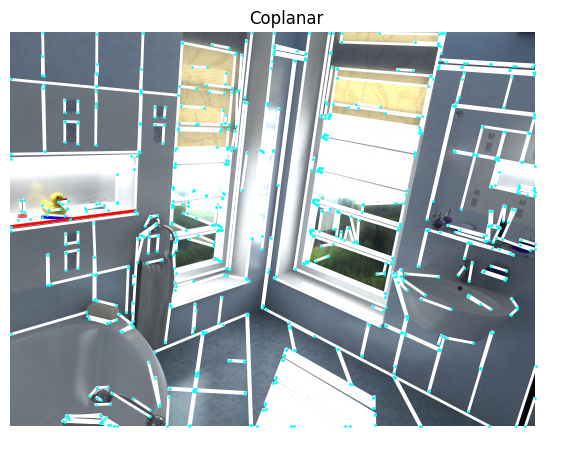

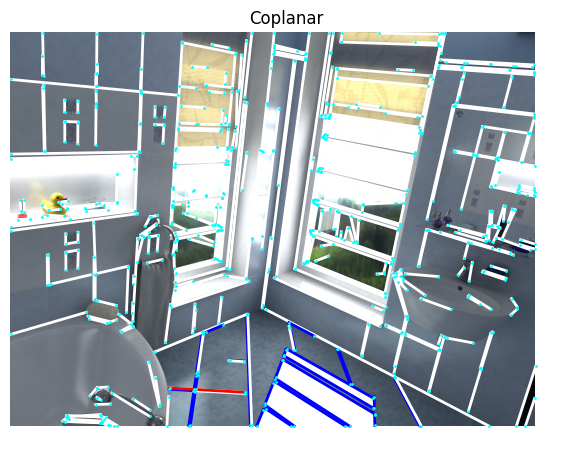

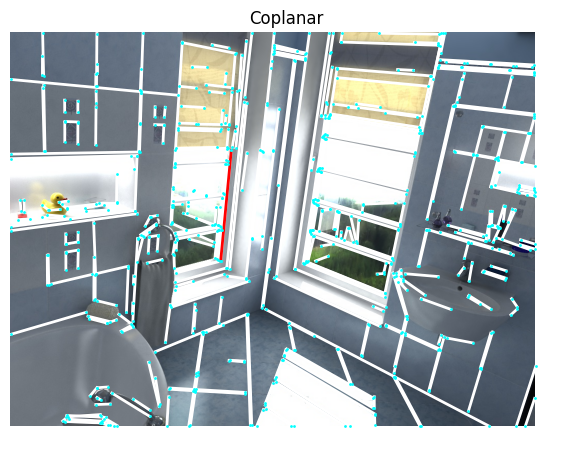

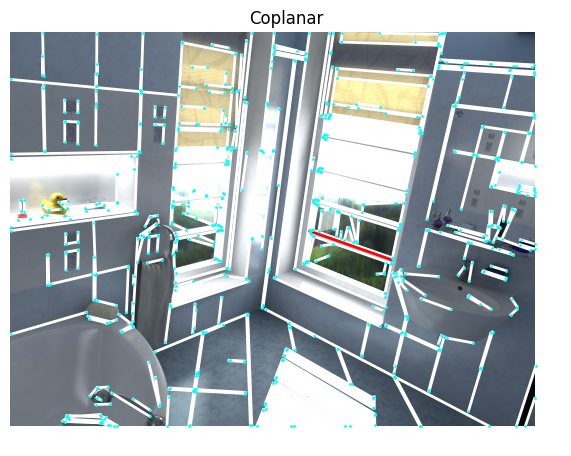

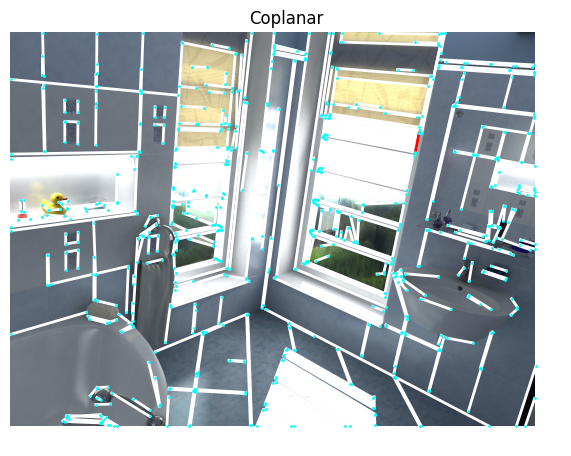

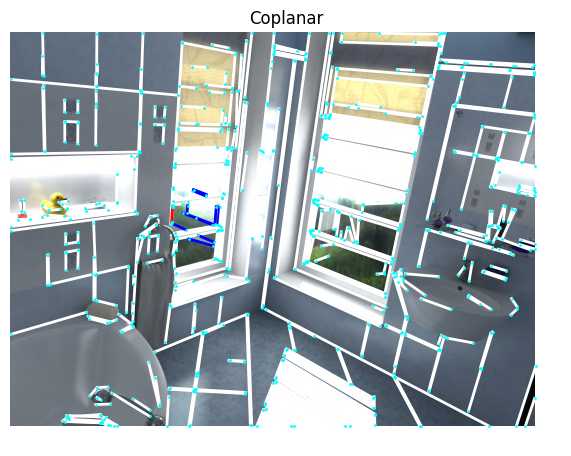

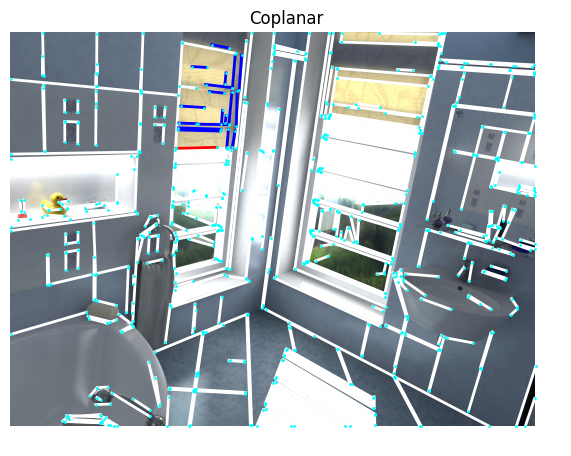

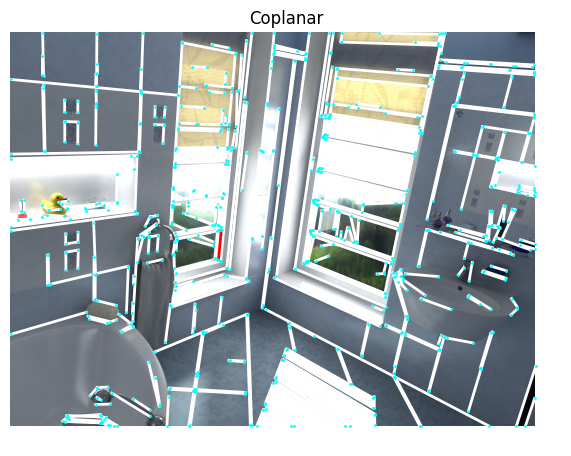

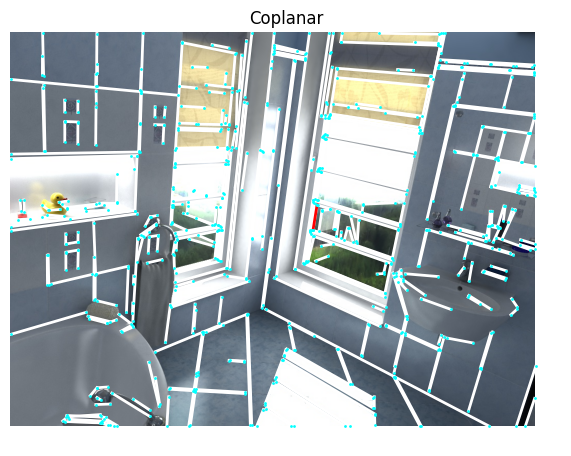

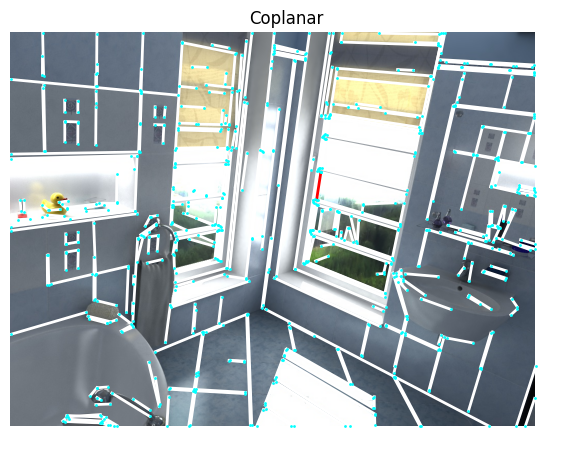

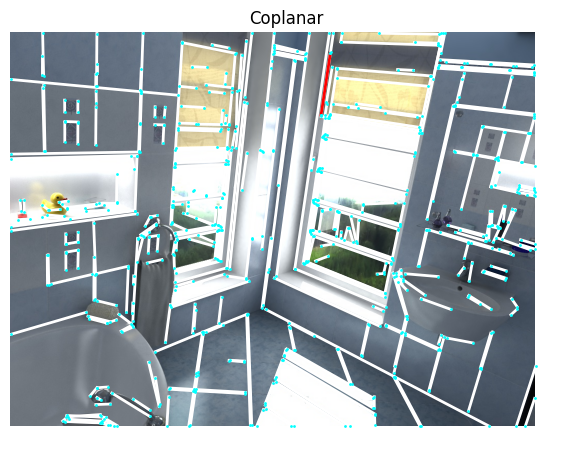

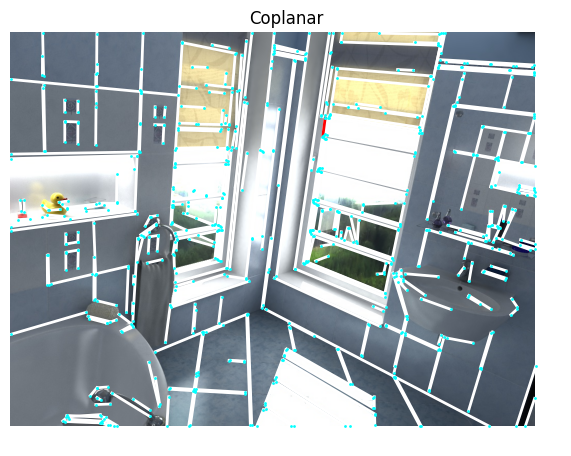

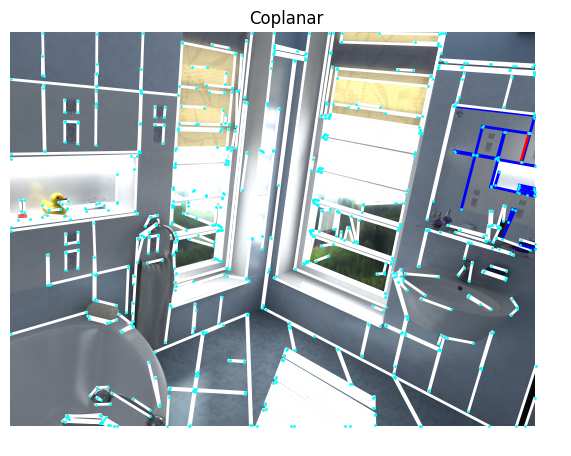

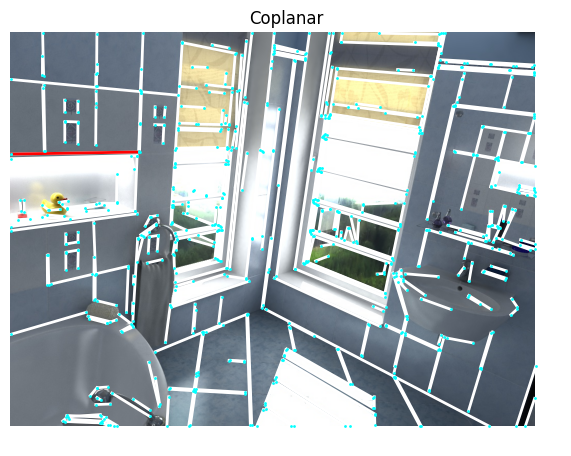

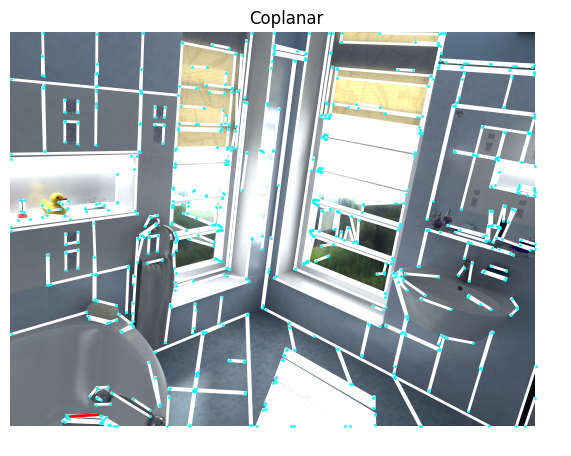

In [97]:
def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'white' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)

for i in range(20,35):
    plot_images([img], ['Coplanar'], cmaps='gray')

    plot_lines_struct([pred_lines], coplanar_dict[i], indices=range(1))
    plot_lines([pred_lines[max(i, 0):i+1]], "red",indices=range(1))

9.396872198806568
0.2082565558200232
-0.3911553896903832
Lines depth
Lines normal


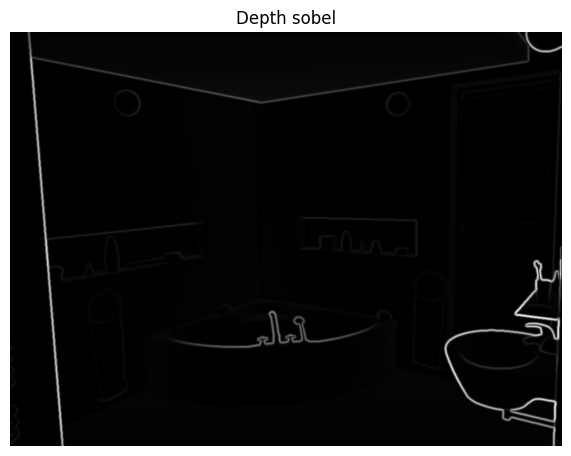

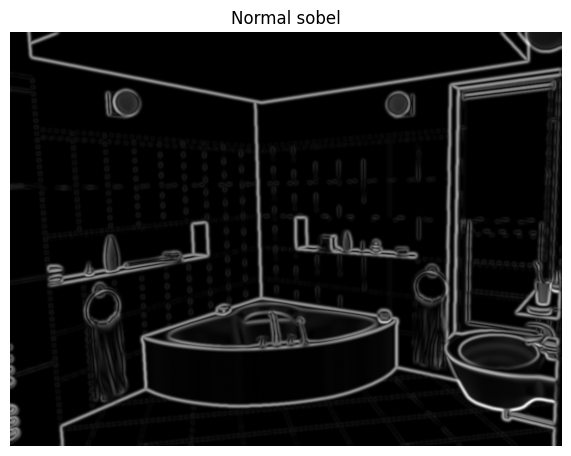

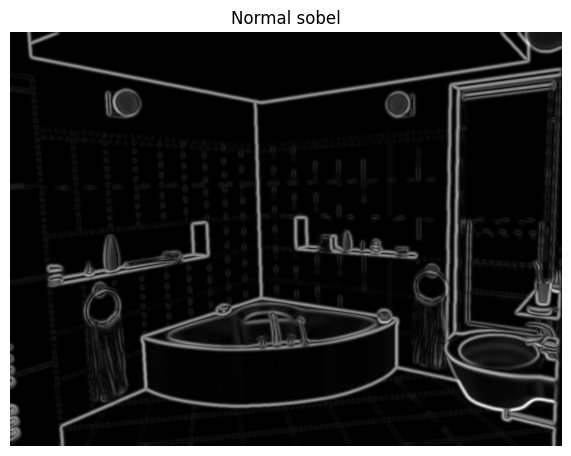

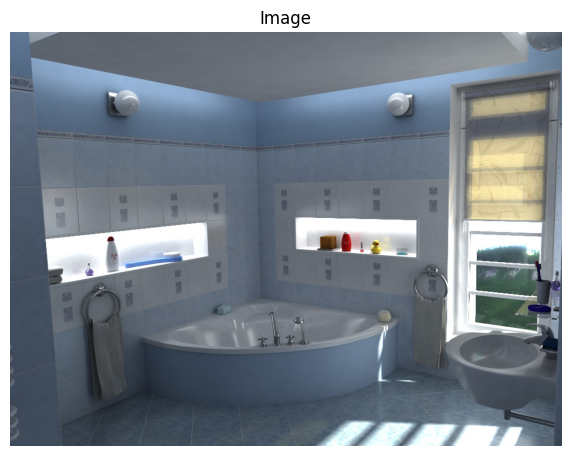

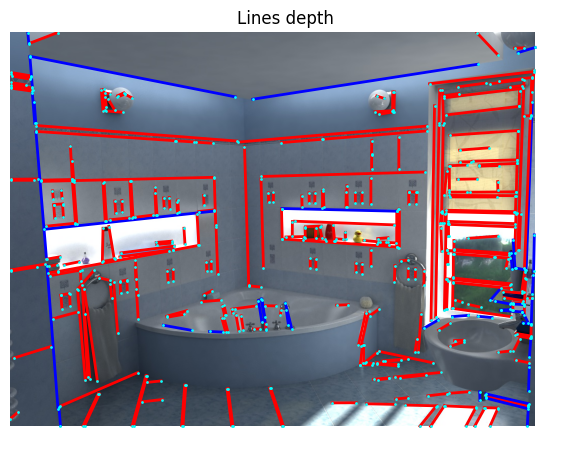

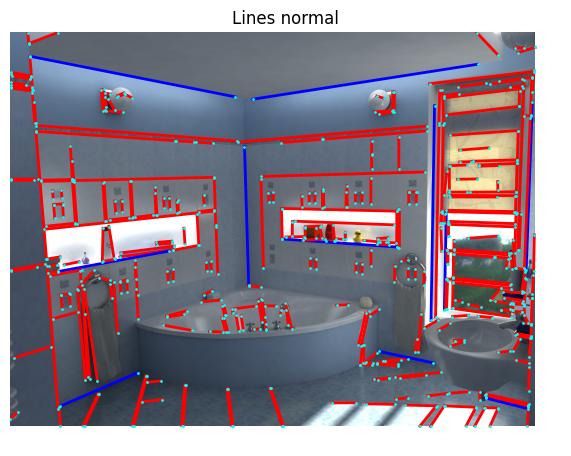

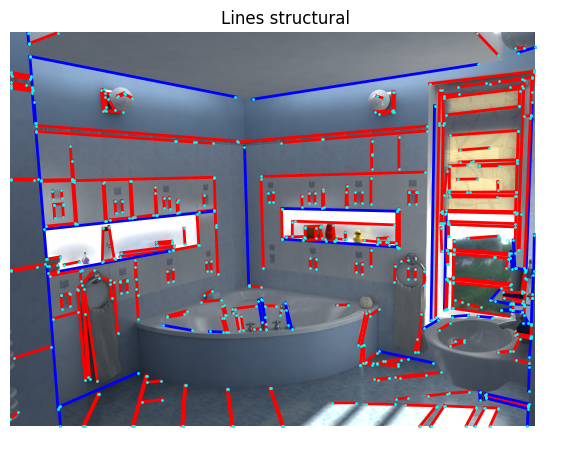

In [188]:


# Compute depth variation
def compute_variation(depth, k):
    depth_grad_x = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=k)
    depth_grad_y = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=k)
    depth_variation = np.sqrt(depth_grad_x**2 + depth_grad_y**2)

    mean = np.mean(depth_variation)
    std_dev = np.std(depth_variation)
    normalized_matrix = (depth_variation - mean) / std_dev

    return normalized_matrix
# Classify lines


sobel_depth_map = compute_variation(depth_map,11)
sobel_normal_map = compute_variation(normal_map, 27)
bump_sobel_normal_map = compute_variation(bump_normal_map, 27)

sobel_normal_map = np.max(sobel_normal_map, axis=2, keepdims=True)
bump_sobel_normal_map = np.max(bump_sobel_normal_map, axis=2, keepdims=True)


print(np.max(sobel_normal_map))
print(np.mean(sobel_normal_map))
print(np.min(sobel_normal_map))

plot_images([sobel_depth_map], ["Depth sobel"], cmaps='gray')
plot_images([(sobel_normal_map)], ['Normal sobel'], cmaps='gray')
plot_images([(bump_sobel_normal_map)], ['Normal sobel'], cmaps='gray')



# temp = sobel_normal_map.copy()
# temp[temp < 1] = 0
# plot_images([temp], ['Normal sobel'], cmaps='gray')

def sobel_line(sobel_depth, sobel_normal, line):
    #x1, y1, x2, y2 = map(int, line)
    x1, y1, x2, y2 = int(line[0,0]), int(line[0,1]), int(line[1,0]), int(line[1,1])
    line_values_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1) * sobel_depth
    line_values_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1) * sobel_normal

    return line_values_depth, line_values_normal

isdepth =[]
isnormal = []
isstruct = []
## Depth should be higher than 0.000008
for l in (pred_lines):
    sobel_depths, sobel_normals = sobel_line(sobel_depth_map, sobel_normal_map, l)
    depthbool = np.mean(sobel_depths) > 0.0001
    #depthbool = np.max(sobel_depths) > 0.00000005 #or np.mean(sobel_depths) < 0.01
    normalbool = np.mean((sobel_normals)) > 0.0005

    isdepth.append(depthbool)
    isnormal.append(normalbool)
    isstruct.append(depthbool or normalbool)
  


def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)
plot_images([img], ['Image'], cmaps='gray')
# Plot the predictions
print("Lines depth")
plot_images([img], ['Lines depth'], cmaps='gray')
plot_lines_struct([pred_lines], isdepth, indices=range(1))

print("Lines normal")
plot_images([img], ['Lines normal'], cmaps='gray')
plot_lines_struct([pred_lines], isnormal, indices=range(1))

plot_images([img], ['Lines structural'], cmaps='gray')
plot_lines_struct([pred_lines], isstruct, indices=range(1))

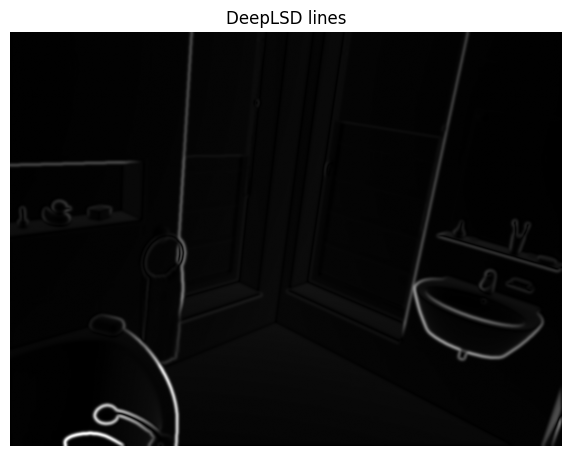

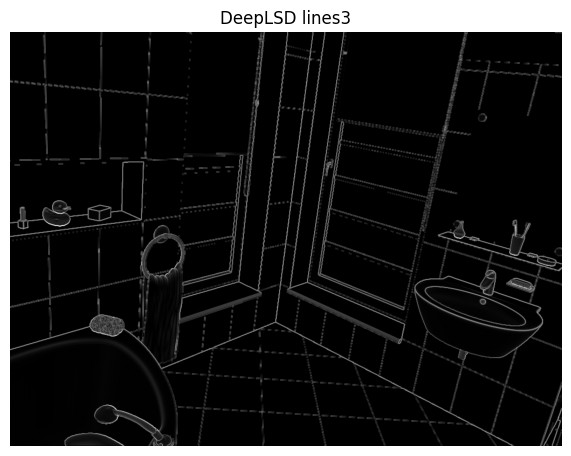

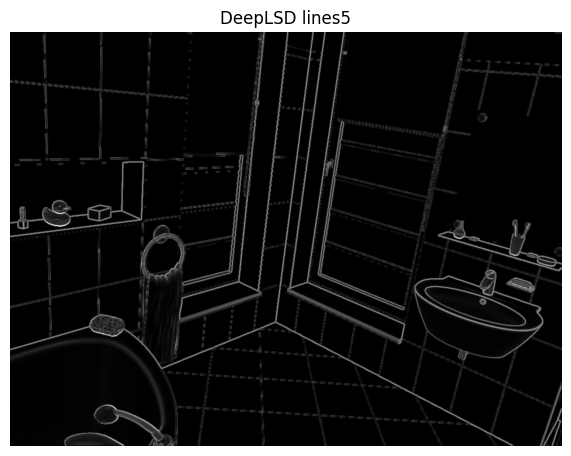

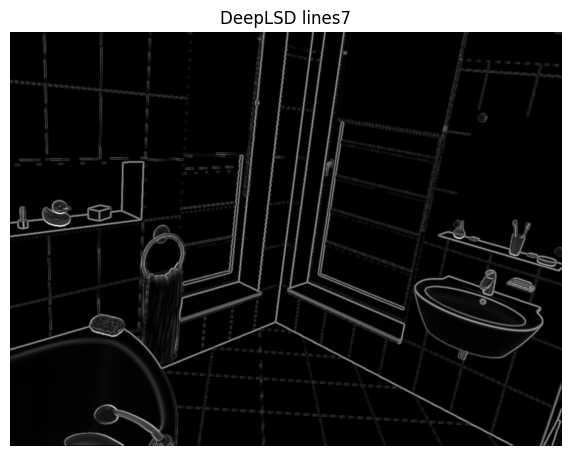

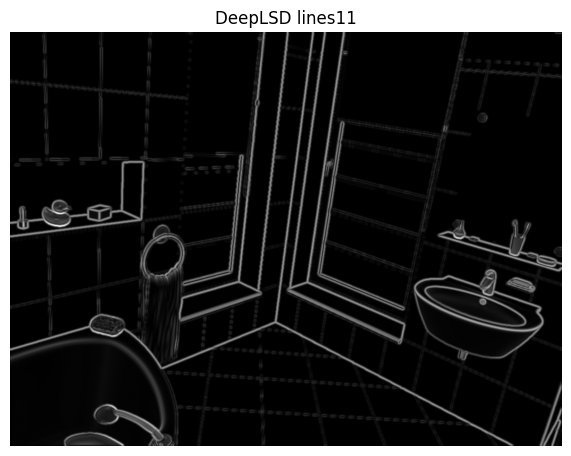

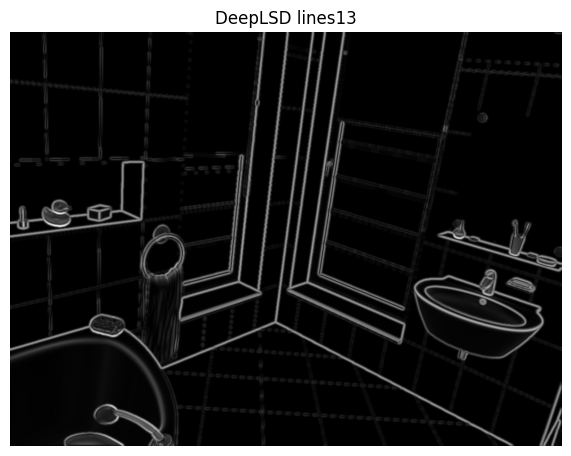

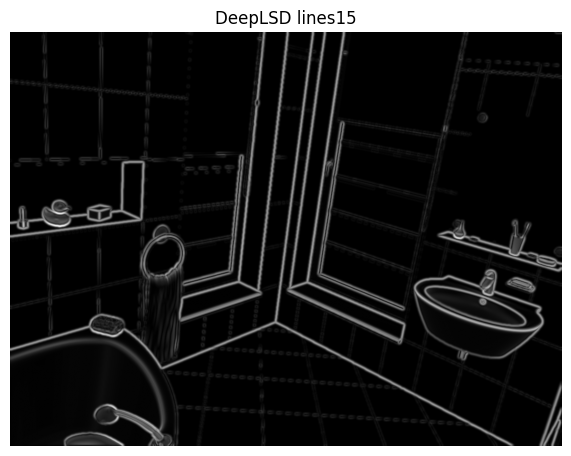

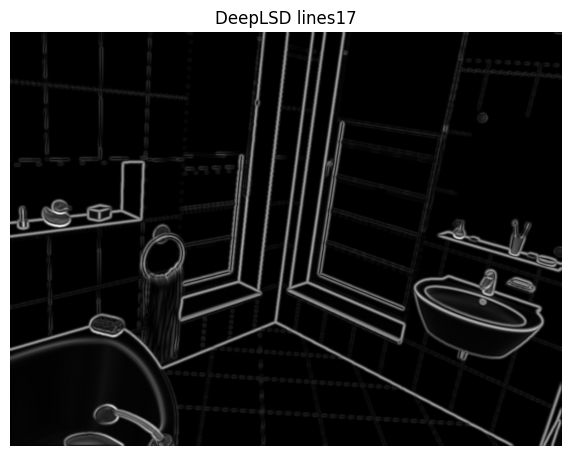

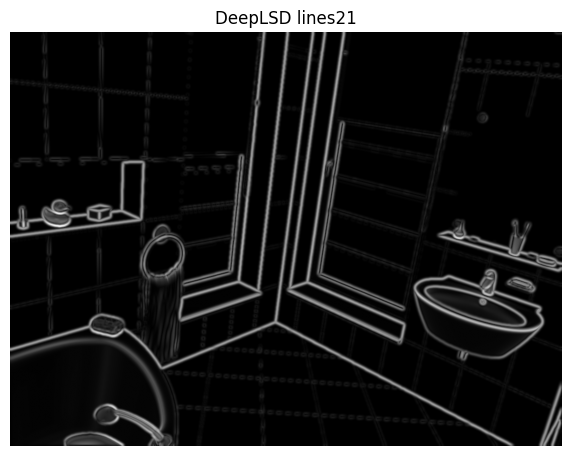

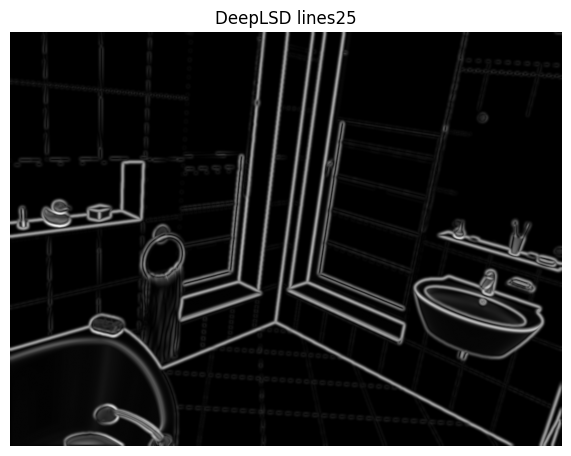

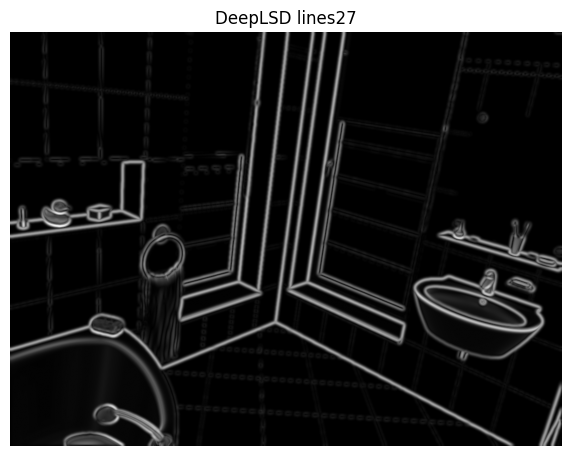

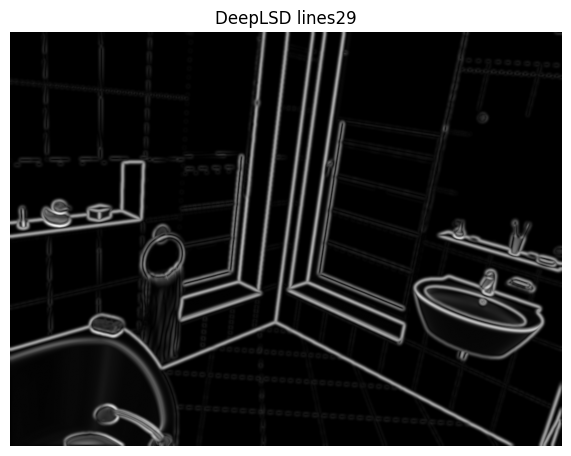

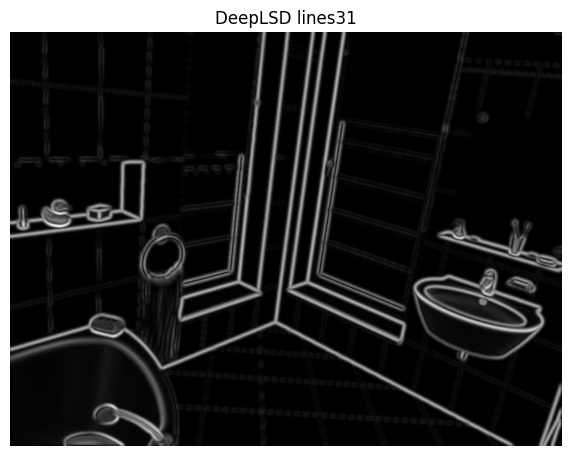

In [171]:

sobel_depth31 = compute_variation(depth_map,31)
plot_images([sobel_depth31], ['DeepLSD lines'], cmaps='gray')

for i in [3,5,7,11,13, 15,17,21,25,27, 29, 31]:
    sobel_normal = compute_variation(normal_map, i)
    sobel_normal_map = np.max(sobel_normal, axis=2, keepdims=True)
    plot_images([sobel_normal_map], ['DeepLSD lines'+ str(i)], cmaps='gray')
